# PRODUCTION GRAPHS

In [2]:
from sklearn.linear_model import Ridge, ElasticNet, SGDRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

In [14]:
import shelve
from stockfish_project.scripts.utils import get_variable



db_name = 'stockfish_data_01'

concept_data = get_variable('concept_data_14', db_name)
df = pd.DataFrame(concept_data)

c_columns = [c for c in df.columns if 'c_' == c[:2]]
c_columns


print(f'df shape: {df.shape}')
df = (
    df
    .assign(NNUE = df.NNUE.astype(float))
    .assign(classical_14 = df.classical_14.astype(float))
    .assign(final_14 = df.final_14.astype(float))
)
print(f'df shape: {df.shape}')

df shape: (94265, 40)
df shape: (94265, 40)


# CHAPTER 1

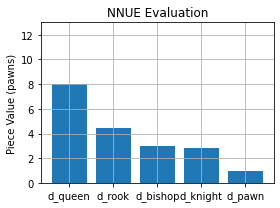

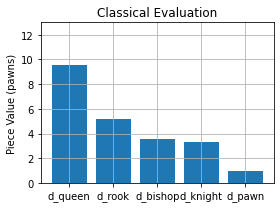

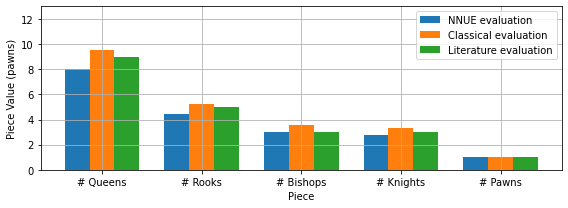

In [15]:
def get_piece_value_concepts(df, 
                           target_name='NNUE', 
                           input_columns = ['d_queen',
                                             'd_pawn',
                                             'd_rook',
                                             'd_knight',
                                             'd_bishop'],
                           test_size = 0.33, 
                           preprocess = False):
    model = Ridge(alpha=1)
    #model = ElasticNet(alpha=1, l1_ratio=1)
    
    c_columns = [c for c in df.columns if 'c_' == c[:2]]
    df_ = (
        df
        .query(' | '.join([f'{c} != 0' for c in input_columns]))
        .query(' | '.join([f'{c} != 0' for c in c_columns]))
    )
    
    
    
    X = df_[input_columns]
    y = df_[[target_name]].astype(float)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    if preprocess: X_train = StandardScaler().fit_transform(X_train)
    model.fit(X_train, y_train)
    df_concept = pd.Series(model.coef_[0], index=input_columns)
    
    df_concept /= df_concept.loc['d_pawn']

    return df_concept


target_name='NNUE'
input_columns = ['d_queen',
                 'd_rook',
                 'd_bishop',
                 'd_knight',
                 'd_pawn']
fig_size = (4,3)
df_concept = get_piece_value_concepts(df, target_name=target_name, input_columns = input_columns, test_size = 0.33, preprocess = False)
plt.figure(figsize = fig_size)
plt.bar(df_concept.index, df_concept.values)
plt.ylim([0,13])
plt.title('NNUE Evaluation')
plt.ylabel('Piece Value (pawns)')
plt.tight_layout()
plt.grid()
#plt.savefig('../figures/piece_value_nnue.png', facecolor='w')

target_name='classical_14'
input_columns = ['d_queen',
                 'd_rook',
                 'd_bishop',
                 'd_knight',
                 'd_pawn',]
df_concept2 = get_piece_value_concepts(df, target_name=target_name, input_columns = input_columns, test_size = 0.33, preprocess = False)
plt.figure(figsize = fig_size)
plt.bar(df_concept2.index, df_concept2.values)
plt.ylim([0,13])
plt.title('Classical Evaluation')
plt.ylabel('Piece Value (pawns)')
plt.tight_layout()
plt.grid()
#plt.savefig('../figures/piece_value_classical.png', facecolor='w')



plt.figure(figsize = (8,3))

r = np.arange(len(df_concept.values))
width = 0.25


plt.bar(r, df_concept.values, width = width, label = 'NNUE evaluation')
plt.bar(r+width, df_concept2.values, width = width, label = 'Classical evaluation')
plt.bar(r+2*width, [9,5,3,3,1], width = width, label = 'Literature evaluation')
plt.ylabel('Piece Value (pawns)')
plt.legend()
plt.xticks(r + width,['# '+x[2:].capitalize()+'s' for x in df_concept2.index])
plt.ylim([0,13])
plt.xlabel('Piece')
plt.grid()#True, color = "grey", linewidth = "1.4", linestyle = "-.")
plt.tight_layout()
plt.savefig('../figures/production/both_piece_value_classical.pdf', facecolor='w')



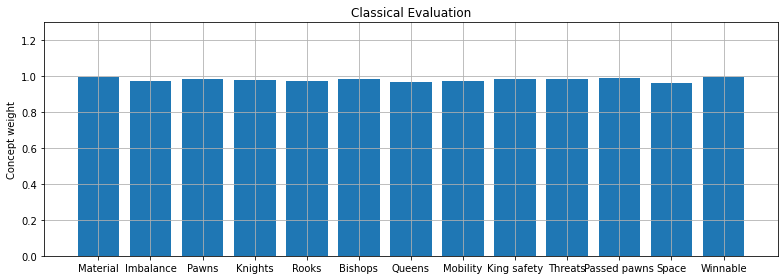

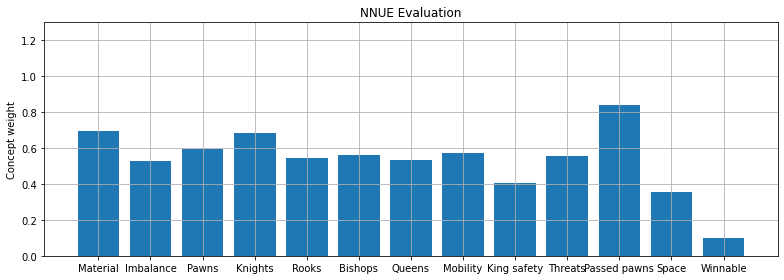

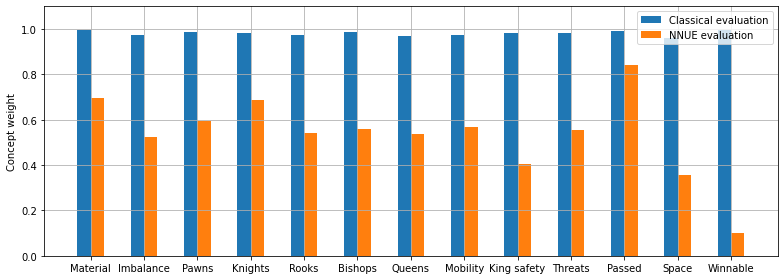

In [16]:
def get_stockfish_concepts(df, target = 'NNUE', test_size = 0.33, preprocess = False):
    model = Ridge(alpha=1)
    input_columns = [x for x in df.columns if x[:2] == 'c_']
    
    
    c_columns = [c for c in df.columns if 'c_' == c[:2]]
    df_ = (
        df
        #.query(' | '.join([f'{c} != 0' for c in input_columns]))
        .query(' | '.join([f'{c} != 0' for c in c_columns]))
    )
    
    
    
    X = df_[input_columns]
    y = df_[[target]].astype(float)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    if preprocess: X_train = StandardScaler().fit_transform(X_train)
    model.fit(X_train, y_train)
    df_concept = pd.Series(model.coef_[0], index=input_columns)

    return df_concept


    
fig_size = (11,4)    

target_name = 'classical_14'
df_concept = get_stockfish_concepts(df, target = target_name)
plt.figure(figsize = fig_size)
plt.bar([x.replace('c_','').replace('_',' ').capitalize() for x in df_concept.index], df_concept.values)
plt.ylabel('Concept weight')
plt.title('Classical Evaluation')
plt.tight_layout()
plt.ylim([0,1.3])
plt.grid()#True, color = "grey", linewidth = "1.4", linestyle = "-.")
#plt.savefig('../figures/classical_all_concept_evaluation.png', facecolor='w')

target_name = 'NNUE'
df_concept2 = get_stockfish_concepts(df, target = target_name)
plt.figure(figsize = fig_size)
plt.bar([x.replace('c_','').replace('_',' ').capitalize() for x in df_concept2.index], df_concept2.values)
plt.ylabel('Concept weight')
plt.title('NNUE Evaluation')
plt.tight_layout()
plt.ylim([0,1.3])
plt.grid()#True, color = "grey", linewidth = "1.4", linestyle = "-.")
#plt.savefig('../figures/nnue_all_concept_evaluation.png', facecolor='w')

plt.figure(figsize = fig_size)

r = np.arange(len(df_concept.values))
width = 0.25

plt.bar(r, df_concept.values, width = width, label = 'Classical evaluation')
plt.bar(r+width, df_concept2.values, width = width, label = 'NNUE evaluation')
plt.ylabel('Concept weight')
plt.legend()
plt.xticks(r + width/2,[x.replace('passed_pawns','passed').replace('c_','').replace('_',' ').capitalize() for x in df_concept2.index])
plt.ylim([0,1.1])
plt.grid()#True, color = "grey", linewidth = "1.4", linestyle = "-.")
plt.tight_layout()
plt.savefig('../figures/production/both_all_concept_evaluation.pdf', facecolor='w')




df shape: (94265, 40)
df shape: (91548, 40)
classical_14 base score: 0.9997371313925286
df shape: (94265, 40)
df shape: (91537, 40)
NNUE base score: 0.7099625625736433


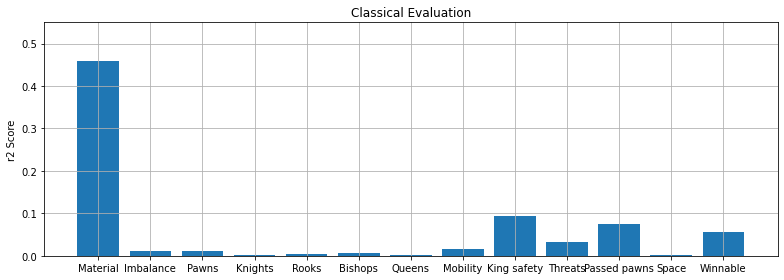

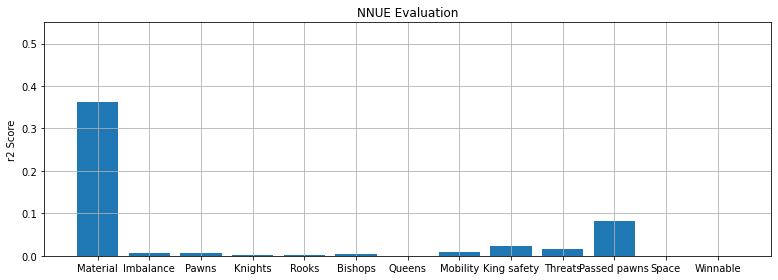

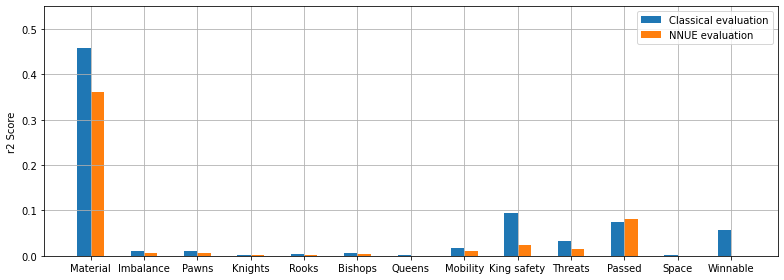

In [18]:
from sklearn.metrics import r2_score
import copy

def get_stockfish_concepts(df, target = 'NNUE', test_size = 0.33, preprocess = False):
    model = Ridge(alpha=1)
    test_lim = 15
    input_columns = [x for x in df.columns if x[:2] == 'c_']
    
    
    c_columns = [c for c in df.columns if 'c_' == c[:2]]
    
    
    print(f'df shape: {df.shape}')
    df_ = (
        df
        .query(f'{target} < {test_lim}')
        .query(f'{target} > -{test_lim}')
        .query(' | '.join([f'{c} != 0' for c in c_columns]))
    )
    print(f'df shape: {df_.shape}')
    
    
    X = df_[input_columns]
    y = df_[[target]].astype(float)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    base_score = r2_score(y_test, y_pred)
    
    
    print(f'{target} base score: {base_score}')
    
    scores = {}
    for col in input_columns:
        input_columns_ = copy.copy(input_columns)
        input_columns_.remove(col)
        
        
    
    
        X = df_[input_columns_]
        y = df_[[target]].astype(float)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
        if preprocess: X_train = StandardScaler().fit_transform(X_train)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        score = r2_score(y_test, y_pred)
        
        scores[col] = (base_score - score)/base_score
        
    df_concept = pd.Series(scores)

    return df_concept



    
fig_size = (11,4)   
ylim = [0,0.55]
y_label = 'r2 Score'

target_name = 'classical_14'
df_concept = get_stockfish_concepts(df, target = target_name)
plt.figure(figsize = fig_size)
plt.bar([x.replace('c_','').replace('_',' ').capitalize() for x in df_concept.index], df_concept.values)
plt.ylabel(y_label)
plt.title('Classical Evaluation')
plt.tight_layout()
plt.ylim(ylim)
plt.grid()#True, color = "grey", linewidth = "1.4", linestyle = "-.")
#plt.savefig('../figures/classical_all_concept_evaluation.png', facecolor='w')

target_name = 'NNUE'
df_concept2 = get_stockfish_concepts(df, target = target_name)
plt.figure(figsize = fig_size)
plt.bar([x.replace('c_','').replace('_',' ').capitalize() for x in df_concept2.index], df_concept2.values)
plt.ylabel(y_label)
plt.title('NNUE Evaluation')
plt.tight_layout()
plt.ylim(ylim)
plt.grid()#True, color = "grey", linewidth = "1.4", linestyle = "-.")
#plt.savefig('../figures/nnue_all_concept_evaluation.png', facecolor='w')

plt.figure(figsize = fig_size)

r = np.arange(len(df_concept.values))
width = 0.25

plt.bar(r, df_concept.values, width = width, label = 'Classical evaluation')
plt.bar(r+width, df_concept2.values, width = width, label = 'NNUE evaluation')
plt.ylabel(y_label)
plt.legend()
plt.xticks(r + width/2,[x.replace('passed_pawns','passed').replace('c_','').replace('_',' ').capitalize() for x in df_concept2.index])
plt.ylim(ylim)
plt.grid()#True, color = "grey", linewidth = "1.4", linestyle = "-.")
plt.tight_layout()
plt.savefig('../figures/production/relative_additive_r2_score.pdf', facecolor='w')




df shape: (94265, 40)
df shape: (94265, 40)
df shape: (94265, 40)
df shape: (94265, 40)


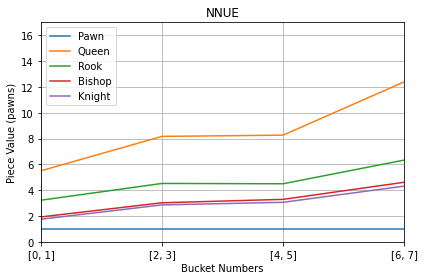

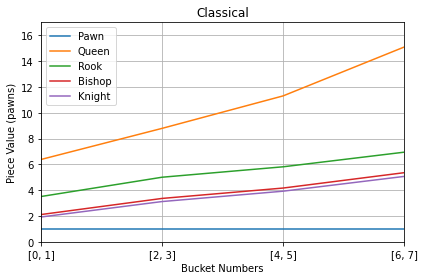

In [8]:
def get_piece_values_per_bucket(df, target_name = 'NNUE', test_size = 0.33, preprocess = False):
    # TODO: are we calculating bucket correctly?
    
    
    c_columns = [c for c in df.columns if 'c_' == c[:2]]
    
    test_lim = 25
    print(f'df shape: {df.shape}')
    df_ = (
        df
        .query(f'{target_name} < {test_lim}')
        .query(f'{target_name} > -{test_lim}')
        .query(' | '.join([f'{c} != 0' for c in c_columns]))
    )
    print(f'df shape: {df.shape}')
    

    series_list = []
    for bucket in [[0,1], [2,3], [4,5], [6,7]]: #sorted(df['bucket'].unique()):
        sub_df = df_[df_['bucket'].isin(bucket)].copy()
        model = Ridge(alpha=1)
        input_columns = ['d_pawn', 'd_queen', 'd_rook', 'd_bishop', 'd_knight']
        X = sub_df[input_columns]
        y = sub_df[[target_name]].astype(float)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
        if preprocess: X_train = StandardScaler().fit_transform(X_train)
        model.fit(X_train, y_train)
        
        
        input_columns_name = [x[2:].capitalize() for x in input_columns]
        
        df_concept = pd.Series(model.coef_[0], index=input_columns_name, name = str(bucket))
        series_list.append(df_concept)
    return pd.DataFrame(series_list)


norm_with_pawn = True
fig_size = (6,4)


target_name = 'NNUE'
df_pv_bucket = get_piece_values_per_bucket(df, target_name = target_name)
if norm_with_pawn: df_pv_bucket = df_pv_bucket.div(df_pv_bucket[['Pawn']].values)
plt.figure(figsize = fig_size)
for label, concept in df_pv_bucket.items():
    plt.plot(concept.index, concept.values, label = label)
plt.legend(loc='upper left')
plt.xlabel('Bucket Numbers')
plt.ylabel('Piece Value (pawns)')
plt.ylim([0,17])
plt.title(f'NNUE')
plt.xlim([0,3])
plt.grid()
plt.tight_layout()
plt.savefig('../figures/production/piece_value_per_bucket_NNUE.pdf', facecolor='w')




target_name = 'classical_14'
df_pv_bucket = get_piece_values_per_bucket(df, target_name = target_name)
if norm_with_pawn: df_pv_bucket = df_pv_bucket.div(df_pv_bucket[['Pawn']].values)
plt.figure(figsize = fig_size)
for label, concept in df_pv_bucket.items():
    plt.plot(concept.index, concept.values, label = label)
plt.legend(loc='upper left')
plt.xlabel('Bucket Numbers')
plt.ylabel('Piece Value (pawns)')
plt.ylim([0,17])
plt.title(f'Classical')
plt.xlim([0,3])
plt.grid()
plt.tight_layout()
plt.savefig('../figures/production/piece_value_per_bucket_classical.pdf', facecolor='w')

df shape: (94265, 40)
df shape: (94265, 40)
classical_14 base score: 0.999618641776374
classical_14 base score: 0.999691565916365
classical_14 base score: 0.9996706036965275
classical_14 base score: 0.9992239847750817
df shape: (94265, 40)
df shape: (94265, 40)
NNUE base score: 0.8428098467178242
NNUE base score: 0.7806723228304377
NNUE base score: 0.6749499632512342
NNUE base score: 0.6141215589828498


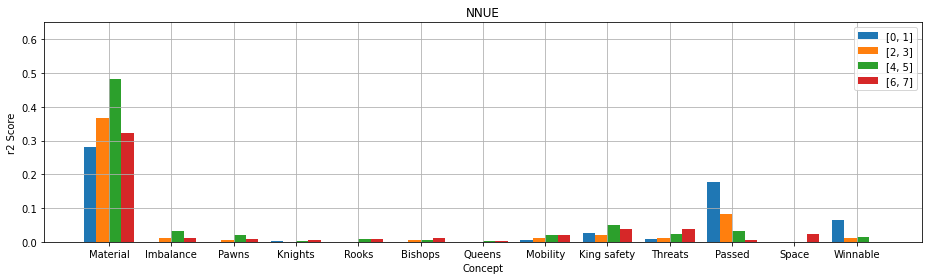

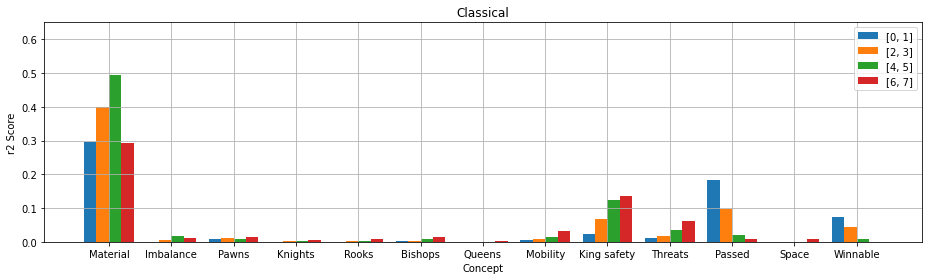

In [10]:
from sklearn.metrics import r2_score
from sklearn.linear_model import (ElasticNet, LogisticRegression, Ridge,
                                  RidgeClassifier, SGDRegressor, LinearRegression)
import copy

def get_stockfish_concepts(df, target = 'NNUE', test_size = 0.33, preprocess = False):
    #model = ElasticNet()
    model = ElasticNet(alpha=0.001, l1_ratio=1)
    test_lim = 15
    input_columns = [x for x in df.columns if x[:2] == 'c_']
    c_columns = [c for c in df.columns if 'c_' == c[:2]]
    
    
    print(f'df shape: {df.shape}')
    df_ = (
        df
        .query(f'{target} < {test_lim}')
        .query(f'{target} > -{test_lim}')
        .query(' | '.join([f'{c} != 0' for c in c_columns]))
    )
    print(f'df shape: {df.shape}')
    
    
    series_list = []
    for bucket in [[0,1], [2,3], [4,5], [6,7]]: #sorted(df['bucket'].unique()):
        sub_df = df_[df_['bucket'].isin(bucket)].copy()
    
    
        X = sub_df[input_columns]
        y = sub_df[[target]].astype(float)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        base_score = r2_score(y_test, y_pred)


        print(f'{target} base score: {base_score}')

        scores = {}
        for col in input_columns:
            input_columns_ = copy.copy(input_columns)
            input_columns_.remove(col)




            X = sub_df[input_columns_]
            y = sub_df[[target]].astype(float)

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
            if preprocess: X_train = StandardScaler().fit_transform(X_train)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            score = r2_score(y_test, y_pred)

            scores[col] = (base_score - score)/base_score

        df_concept = pd.Series(scores, name = str(bucket))
        series_list.append(df_concept)

    return pd.DataFrame(series_list)



    
fig_size = (11,4)   
ylim = [0,0.55]
y_label = 'r2 Score'

target_name = 'classical_14'
df_concept = get_stockfish_concepts(df, target = target_name)

target_name = 'NNUE'
df_concept2 = get_stockfish_concepts(df, target = target_name)



fig_size = (13,4)   
ylim = [0,0.55]
y_label = 'r2 Score'

plt.figure(figsize = fig_size)


r = np.arange(len(df_concept2.iloc[0,:].values))
width = 0.2

plt.bar(r, df_concept2.iloc[0,:].values, width = width, label = df_concept2.iloc[0,:].name)
plt.bar(r+width, df_concept2.iloc[1,:].values, width = width, label = df_concept2.iloc[1,:].name)
plt.bar(r+2*width, df_concept2.iloc[2,:].values, width = width, label = df_concept2.iloc[2,:].name)
plt.bar(r+3*width, df_concept2.iloc[3,:].values, width = width, label = df_concept2.iloc[3,:].name)
plt.ylabel(y_label)
plt.title('NNUE')
plt.legend()
plt.xticks(r + 1.5*width,[x[2:].replace('_pawns','').replace('_',' ').capitalize() for x in df_concept2.iloc[0,:].index])
plt.ylim([0,0.65])
plt.xlabel('Concept')
plt.grid()#True, color = "grey", linewidth = "1.4", linestyle = "-.")
plt.tight_layout()
plt.savefig('../figures/production/phase_concept_contributions.pdf', facecolor='w')




plt.figure(figsize = fig_size)


r = np.arange(len(df_concept.iloc[0,:].values))
width = 0.2

plt.bar(r, df_concept.iloc[0,:].values, width = width, label = df_concept.iloc[0,:].name)
plt.bar(r+width, df_concept.iloc[1,:].values, width = width, label = df_concept.iloc[1,:].name)
plt.bar(r+2*width, df_concept.iloc[2,:].values, width = width, label = df_concept.iloc[2,:].name)
plt.bar(r+3*width, df_concept.iloc[3,:].values, width = width, label = df_concept.iloc[3,:].name)
plt.ylabel(y_label)
plt.title('Classical')
plt.legend()
plt.xticks(r + 1.5*width,[x[2:].replace('_pawns','').replace('_',' ').capitalize() for x in df_concept2.iloc[0,:].index])
plt.ylim([0,0.65])
plt.xlabel('Concept')
plt.grid()#True, color = "grey", linewidth = "1.4", linestyle = "-.")
plt.tight_layout()
plt.savefig('../figures/production/phase_concept_contributions_classical.pdf', facecolor='w')

df shape: (94265, 40)
df shape: (94265, 40)


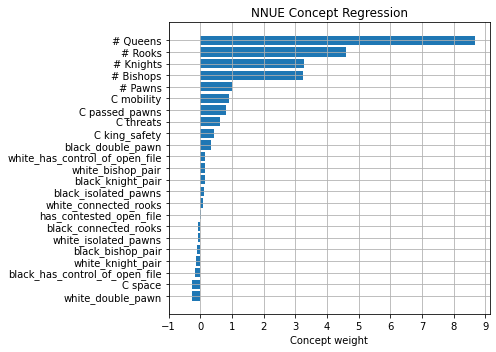

In [12]:
def get_stockfish_concepts(df, target = 'NNUE', test_size = 0.33, preprocess = False):
    model = Ridge(alpha=1)
    input_columns_data = [
                    ('white_bishop_pair','white_bishop_pair'),
                    ('black_bishop_pair',  'black_bishop_pair' ),
                    ('white_knight_pair',  'white_knight_pair' ),
                    ('black_knight_pair', 'black_knight_pair'  ),
                    ('black_double_pawn',  'black_double_pawn' ),
                    ('white_double_pawn',  'white_double_pawn' ),
                    ('black_isolated_pawns', 'black_isolated_pawns'  ),
                    ('white_isolated_pawns',  'white_isolated_pawns' ),
                    ('black_connected_rooks', 'black_connected_rooks'  ),
                    ('white_connected_rooks', 'white_connected_rooks'  ),
                    ('black_has_control_of_open_file', 'black_has_control_of_open_file'  ),
                    ('white_has_control_of_open_file',  'white_has_control_of_open_file' ),
                    ('has_contested_open_file', 'has_contested_open_file'  ),
                    
                    ('c_king_safety', 'C king_safety' ),
                    #('c_imbalance',  'C imbalance' ),
                    #('c_material',  'C material' ),
                    ('c_mobility', 'C mobility'  ),
                    ('c_space',  'C space' ),
                    ('c_threats', 'C threats'  ),
                    ('c_passed_pawns', 'C passed_pawns'  ),
                    
                    ('d_queen',  '# Queens' ),
                    ('d_pawn', '# Pawns'  ),
                    ('d_rook',  '# Rooks' ),
                    ('d_knight',  '# Knights' ),
                    ('d_bishop', '# Bishops'  )
                ]
    
    input_columns = [x[0] for x in input_columns_data]
    input_names = [x[1] for x in input_columns_data]
    
    c_columns = [c for c in df.columns if 'c_' == c[:2]]
    
    
    print(f'df shape: {df.shape}')
    df_ = (
        df
        .query(' | '.join([f'{c} != 0' for c in c_columns]))
    )
    print(f'df shape: {df.shape}')
    
    X = df_[input_columns]
    y = df_[[target]].astype(float)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    if preprocess: X_train = StandardScaler().fit_transform(X_train)
    model.fit(X_train, y_train)
    df_concept = pd.Series(model.coef_[0], index=input_names)

    return df_concept


    
fig_size = (7,5)    

target_name = 'NNUE'
df_concept = get_stockfish_concepts(df, target = target_name)
df_concept = df_concept.sort_values()



df_concept /= df_concept.loc['# Pawns']
plt.figure(figsize = fig_size)
plt.barh([x for x in df_concept.index], df_concept.values)
plt.xlabel('Concept weight')
plt.title('NNUE Concept Regression')
plt.tight_layout()
plt.xticks(list(range(-1,10)))
plt.grid()
plt.savefig('../figures/production/defined_and_classical_concepts.pdf', facecolor='w')
plt.show()

In [136]:
sh = shelve.open(f"/media/ap/storage/stockfish_data/stockfish_data_03")
s = sh['ckpt_data_epoch=0-step=6103.ckpt']
sh.close()

In [141]:
s['layer3'][0].shape

KeyError: 'layer3'

# CHAPTER 2

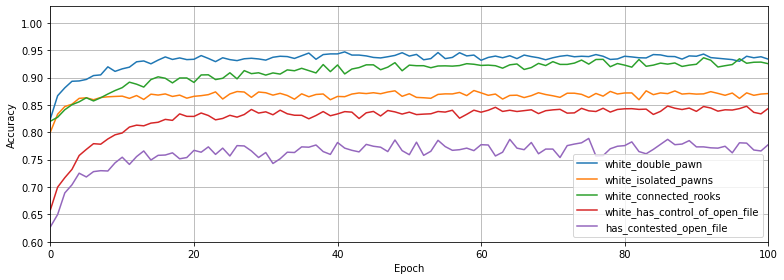

In [120]:
db_name = 'stockfish_data_03'
post_fix = '_t2'




targets = [
         #'white_knight_pair',
         #'black_knight_pair',
         #'white_bishop_pair',
         #'black_bishop_pair',
         #'black_double_pawn',
         'white_double_pawn',
         #'black_isolated_pawns',
         'white_isolated_pawns',
         #'black_connected_rooks',
         'white_connected_rooks',
         #'black_has_control_of_open_file',
         'white_has_control_of_open_file',
         'has_contested_open_file',
         #'is_forking',
         #'can_fork',
         #'can_check',
     ]


for layer_num in [1]:

    plt.figure(figsize = (11,4))

    for target in targets:
        
        
        
        
        concepts = get_variable(f'concept_results_{target}{post_fix}', db_name)

        df_concepts = pd.DataFrame(concepts)
        #pdb.set_trace()

        df_ = df_concepts[df_concepts.layer == layer_num]
        df_ = df_[df_.bucket == 'all']

        plt.plot(df_.epoch, df_.score, label = target)

    plt.legend(loc='lower right')
    #plt.title(f'Concept prediction accuracy on test set: Layer Number {layer_num}')
    plt.ylabel('Accuracy')
    plt.ylim([0.6,1.03])
    plt.xlim([0,100])
    plt.xlabel('Epoch')
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'../figures/production/Layer{layer_num}_stockfish_conepts.pdf', facecolor='w')
    plt.show()
        

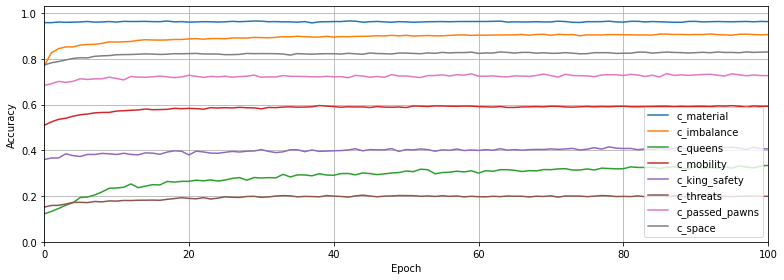

In [118]:
db_name = 'stockfish_data_03'
post_fix = ''




targets = [         
         'c_material',
         'c_imbalance',
         #'c_pawns',
         #'c_knights',
         #'c_rooks',
         #'c_bishops',
         'c_queens',
         'c_mobility',
         'c_king_safety',
         'c_threats',
         'c_passed_pawns',
         'c_space',
     ]


for layer_num in [1]:

    plt.figure(figsize = (11,4))

    for target in targets:
        
        
        
        
        concepts = get_variable(f'concept_results_{target}{post_fix}', db_name)

        df_concepts = pd.DataFrame(concepts)
        #pdb.set_trace()

        df_ = df_concepts[df_concepts.layer == layer_num]
        df_ = df_[df_.bucket == 'all']

        plt.plot(df_.epoch, df_.score, label = target)

    plt.legend(loc='lower right')
    #plt.title(f'Concept prediction accuracy on test set: Layer Number {layer_num}')
    plt.ylabel('Accuracy')
    plt.ylim([0,1.03])
    plt.xlim([0,100])
    plt.xlabel('Epoch')
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'../figures/production/Layer{layer_num}_stockfish_regconepts.pdf', facecolor='w')
    plt.show()
        